In [120]:
###########################################################################
# Copyright 2022-2023 Jean-Luc CHARLES
# Created: 2022-07-29
# version: 1.2 - 3 Dec 2023
# License: GNU GPL-3.0-or-later
###########################################################################

# _Deep Reinforcement Learning_ (DRL)
# Train a PPO neural network control the robot position.

In this notebook you will learn how to use DRL to train a ___PPO___  neural network to control the robot position.

# Outline <a name="top"></a>
- [ 1 $-$ The RoboticArm_2DOF class](#1)
    - [ 1.1 $-$ Instancite the robot](#1.1)
    - [ 1.2 $-$ Run a simple test](#1.2)
- [ 2 $-$ Train the PPO neural network](#2)
    - [ 2.1 $-$ A first _fake_ training to see](#2.1)
    - [ 2.2 $-$ Run the full training](#2.2)
    - [ 2.3 $-$ Find the best training epoch](#2.3)
    - [ 2.4 $-$ Evaluate the trained agent performance](#2.4)

Recommended links:
- Pybullet online documentation: [PyBullet Quickstart Guide](https://docs.google.com/document/d/10sXEhzFRSnvFcl3XxNGhnD4N2SedqwdAvK3dsihxVUA/edit#heading=h.2ye70wns7io3)

# Import the required modules

In [121]:
import os, sys, time, shutil, pathlib, shutil
import pybullet as p
import pybullet_data
import numpy as np
from numpy.linalg import norm       # to get the norm of a vector
from numpy import pi
import matplotlib.pyplot as plt

from utils.tools import is_close_to, display_joint_properties, test_training, sample_line, sample_traj4pts
from utils.tools import welcome, plot_test, moving_average, get_files_by_date

from utils.RoboticArm_2DOF import RoboticArm_2DOF_PyBullet

# the PyBullect connection:
pc = None

# 1. $-$ The RoboticArm_2DOF_PyBullet class <a name="1"></a>

The RoboticArm_2DOF class inherits from the base class `env` of the framework _Gymnasium_.<br>
It is defined in the file `utils/RoboticArm_2DOF.py` with main tasks : 
- Create an instance of the Env class
- Create a PyBullet session
- Instanciate the 2 DOF robot arm in the simulator session using its URDF description file.
- Make the simulated robot move under the actions given by the PPO agent.. 

## 1.1 $-$ Instanciate the robot <a name="1.1"></a>

In [122]:
ROBOT  = "./urdf/RoboticArm_2DOF_2.urdf"
TARGET = "./urdf/target.urdf"

if 'env' in dir(): 
    env.close()
    del env

env = RoboticArm_2DOF_PyBullet(robot_urdf=ROBOT,      # mandatory
                               target_urdf=TARGET,    # mandatory
                               dt=1/240,              # mandatory, time step of the simulation [s] (~4ms) 
                               headless=False,        # to get the PyBullet graphical interface 
                               verbose=2)

[RoboticArm_2DOF_PyBullet.__init__] _max_episode_steps:500

################################################################################
# Welcome to this practical session with Pybullet & URDF.
# Pybullet windows shortcuts:
#    G: close/open the tabs
#    W: switch between solid/wireframe rendering
#    J: show/hide links & joints frames as RGB lines (with wireframe rendering activated)
#    K: show/hide joint axes as a black line         (with wireframe rendering activated)
#    A: show/hide collision boxes                    (with wireframe rendering activated)
#    CTRL+left_clic  : rotate the robot
#    CRTL+midlle_clic: translate the robot
#    Mouse_wheel: zoom/unzoom
################################################################################



## 1.2 - Run a simple kinematic test<a name="1.2"></a>

In this test, the two DOFs of the robot (angles $q_1$ and $q_2$) are controlled by value to make the robot move around its start position.

In [123]:
data = env.testAngleControl(0.075)

[RoboticArm_2DOF_PyBullet.reset] last #steps : 0
[RoboticArm_2DOF_PyBullet.reset] q1:(94.6°, 0.0°/s), q2:(-150.3°, 0.0°/s), Target:(0.295,0.114) m, EndEff:(0.484,0.191) m, after 77 substeps
[testAngleControl] Ready to run the test with timestep=7.50e-02 s
sub_steps: 2
24.42°

-0.00°°

#### Plot the data:

We can verify that the actual values of $q_1$ and $q_2$ are close to the tagrte values (dashed black lines).<br>
We also draw the velocities $\dot{q}_1$ and $\dot{q}_2$, as well as the trajectory of the end effector of the robot:

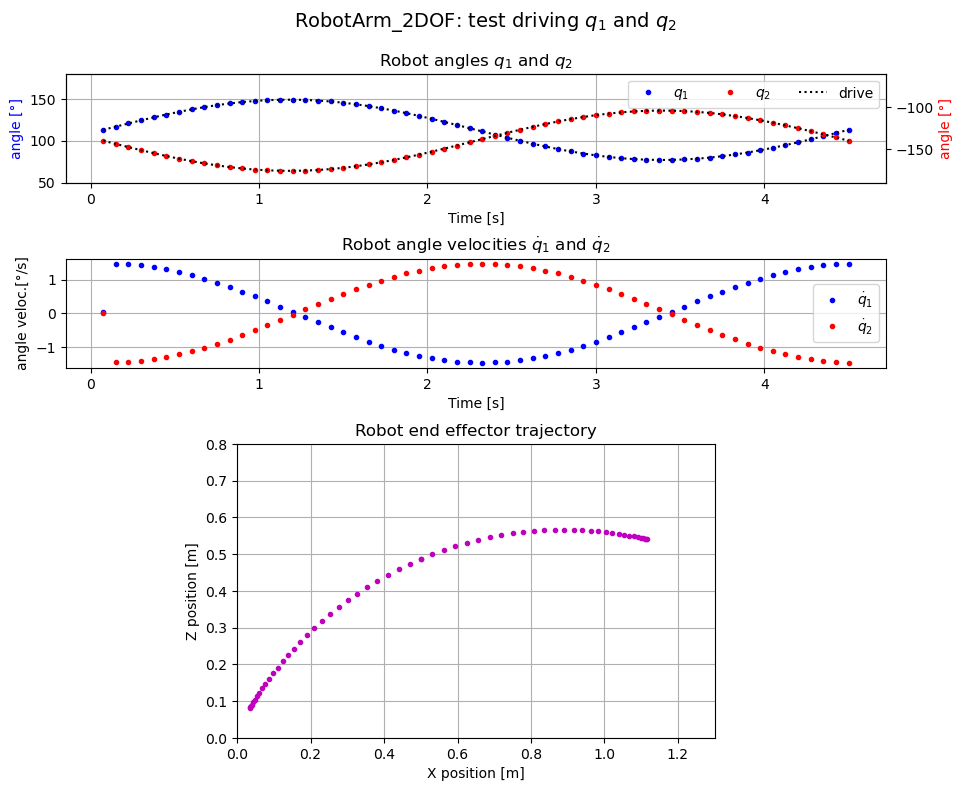

In [124]:
data = data.astype(float)
plot_test(data)

### Try the reset() method

In [125]:
obs = env.reset(options={"target_initial_pos":(0.50, 0, 0.50), 'randomize':True})

[RoboticArm_2DOF_PyBullet.reset] last #steps : 60
[RoboticArm_2DOF_PyBullet.reset] q1:(139.8°, 0.0°/s), q2:(-128.5°, 0.0°/s), Target:(0.536,0.591) m, EndEff:(0.217,0.862) m, after 2 substeps


In [126]:
obs = env.reset(options={"target_initial_pos":(0.50, 0, 0.50), 'randomize':True})

[RoboticArm_2DOF_PyBullet.reset] last #steps : 0
[RoboticArm_2DOF_PyBullet.reset] q1:(130.7°, 0.0°/s), q2:(-164.6°, 0.0°/s), Target:(0.410,0.283) m, EndEff:(0.178,0.221) m, after 2 substeps


In [127]:
obs = env.reset(options={"target_initial_pos":(0.50, 0, 0.50), 'randomize':False})

[RoboticArm_2DOF_PyBullet.reset] last #steps : 0
[RoboticArm_2DOF_PyBullet.reset] q1:(113.0°, 0.0°/s), q2:(-140.0°, 0.0°/s), Target:(0.500,0.500) m, EndEff:(0.500,0.487) m, after 2 substeps


In [128]:
obs = env.reset(options={"target_initial_pos":(0.50, 0, 0.50), 'randomize':False})

[RoboticArm_2DOF_PyBullet.reset] last #steps : 0
[RoboticArm_2DOF_PyBullet.reset] q1:(113.0°, 0.0°/s), q2:(-140.0°, 0.0°/s), Target:(0.500,0.500) m, EndEff:(0.500,0.487) m, after 2 substeps


### Close the environment

When you have done with the `env` object, before creating another `RoboticArm_2DOF_PyBullet` it is important to close the current `env` properly in order to close the Pybullet session ans all what is connected with the environment.

In [129]:
env.close()

[top](#top)

# 2 - Train the PPO neural network <a name="2"></a>

#### Training Strategy

The training of the robot involves a loop on the target position:
- A random target position is choosen in the space reachable by the robot.
- During the training, the reward function encourages the robot to move its end effector as close as possible to the target position.
- When done (the end effector is close enough to the target), a new target position is randomly choosen, and so on...

The whole training process is driven by many __hyperparameters__ including:
- `tot_steps`: the total number of random positions learned before we decide that the network is trained.
- `EPSILON`: the threshold distance between the end effector and the target mass below which the effector is considered close enough to the target.
- `n_epoch`: the (classical) number of training successively run with the same data set.

## 2.1 A first _fake_ training to see <a name="2.1"></a>

You will run now a first _fake_ training to see if all is OK : the purpose of this section is just to show you the steps of a DRL training scenario. <br>
At this stage, you will use the __reward function__ `reward_0` already defined in the file `reward.py` : it returns always 0, so the PPO agent wil not learn anything....<br>

### 2.1.1 Instanciate the robot <a name="2.1.1"></a>

#### Let's define important parameters:

In [130]:
DT      = 1/240          # the simulation time step [s]
EPSILON = 1e-3           # the distance threshold between the end effector and the target
SEED    = 1234567        # the seed for the random generators

Create an instance of `RoboticArm_2DOF_PyBullet`:

In [131]:
ROBOT  = "./urdf/RoboticArm_2DOF_2.urdf"
TARGET = "./urdf/target.urdf"

if 'env' in dir():
    try:
        env.close()
    except:    
        del env

env    = RoboticArm_2DOF_PyBullet(robot_urdf  = ROBOT, 
                                  target_urdf = TARGET, 
                                  dt = DT,
                                  init_robot_angles = (113, -140),
                                  init_target_pos = (0.5, 0, 0.5),
                                  reward = 'reward_0',
                                  seed = SEED,
                                  epsilon = EPSILON,
                                  headless = False,  # turn graphical rendering on for this 'fake' round
                                  max_episode_steps = 256,
                                  verbose=0)

not connected...

################################################################################
# Welcome to this practical session with Pybullet & URDF.
# Pybullet windows shortcuts:
#    G: close/open the tabs
#    W: switch between solid/wireframe rendering
#    J: show/hide links & joints frames as RGB lines (with wireframe rendering activated)
#    K: show/hide joint axes as a black line         (with wireframe rendering activated)
#    A: show/hide collision boxes                    (with wireframe rendering activated)
#    CTRL+left_clic  : rotate the robot
#    CRTL+midlle_clic: translate the robot
#    Mouse_wheel: zoom/unzoom
################################################################################



Call `env.reset` to verify the randomisation of the target and end effector (x,z) positions:

In [132]:
obs = env.reset(options={"target_initial_pos":(0.50, 0, 0.50), 'randomize':True})
obs

(array([ 2.2985072 ,  0.        , -2.681202  ,  0.        ,  1.0035251 ,
         0.23244807,  0.2625554 ,  0.39333388], dtype=float32),
 {})

In [133]:
obs = env.reset(options={"target_initial_pos":(0.50, 0, 0.50), 'randomize':True})
obs

(array([ 1.4965545 ,  0.        , -2.538524  ,  0.        ,  0.83687365,
         0.6502507 ,  0.5787832 ,  0.1538613 ], dtype=float32),
 {})

### 2.1.2 Instanciate the PPO network <a name="2.1.2"></a>

Let's define the PPO training hyperparameters:

In [134]:
policy     = 'MlpPolicy'
tot_steps  = 1000       # only 10000 steps for this 'fake' round
save_freq  = 5000        # save the networks weights every 'save_freq' steps
nb_steps   = 2048        # The number of steps to run per update (the size of the rollout buffer)
nb_epochs  = 10          # number of training iterations with the same dataset
batch_size = 256         # size of the batch to train the network

Define automatically a uniq name for the training directory:

In [135]:
experiment_time = time.localtime()
experiment_id = "_".join(['2DOF_RobotArm_PyBullet', 'PPO', time.strftime("%y-%m-%d_%H-%M-%S", experiment_time)])

training_dir = pathlib.Path('models')/experiment_id
training_dir.mkdir(parents=True, exist_ok=True)

print(f"Training in directory <{training_dir}>")

Training in directory <models\2DOF_RobotArm_PyBullet_PPO_24-01-04_23-18-40>


In [136]:
import torch
print(torch.__version__)


2.1.0


Create the PPO neural network:

In [138]:
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import CheckpointCallback

agent = PPO(policy, 
            env, 
            n_epochs = nb_epochs,
            n_steps = nb_steps,
            batch_size = batch_size,
            use_sde = False,
            seed = SEED,
            tensorboard_log = training_dir,
            verbose=1)

checkpoint_callback = CheckpointCallback(save_freq = save_freq, 
                                         save_path = training_dir/'ZIP')

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


AttributeError: module 'torch' has no attribute '_utils'

Display some details on the actor & critic networks:

In [ ]:
agent.policy

NameError: name 'agent' is not defined

Now train the network<br>
(you can find some explanations of the training display here : https://stable-baselines3.readthedocs.io/en/master/common/logger.html#rollout)


In [ ]:
# train agent
t0 = time.time()

agent.learn(total_timesteps = tot_steps, callback = checkpoint_callback)
    
t = int(time.time()-t0)
h = int(t/3600)
m = int((t - h*3600)/60)
print(f"Training elapsed time: {h:02d}h {m:02d}m")

Logging to models/2DOF_RobotArm_PyBullet_PPO_23-12-08_09-35-55/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 256      |
|    ep_rew_mean     | 0        |
| time/              |          |
|    fps             | 33       |
|    iterations      | 1        |
|    time_elapsed    | 60       |
|    total_timesteps | 2048     |
---------------------------------
Training elapsed time: 00h 01m


<div class="alert alert-block alert-info">
<span style="color: #0000BB;font-weight: bold; font-size:large;">$\blacktriangleright$ Check target positions:</span>
<span style="color: #0000BB">

Using the coordinates `x`and `z` of the attribute `env.target_pos` plot the successive positions of the target during training:
</span></div>    

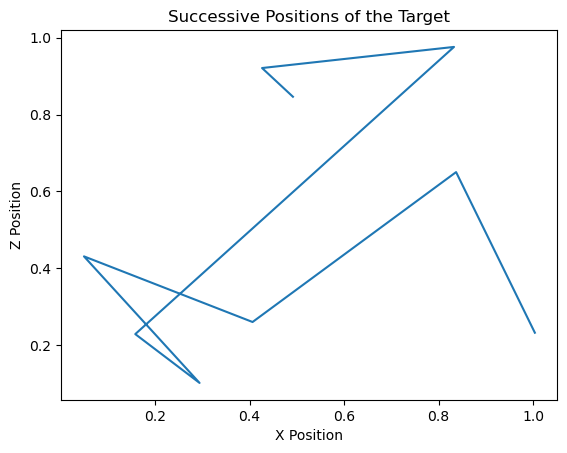

In [ ]:
import matplotlib.pyplot as plt

x_positions = [pos[0] for pos in env.target_pos]
z_positions = [pos[2] for pos in env.target_pos]

plt.plot(x_positions, z_positions)
plt.xlabel('X Position')
plt.ylabel('Z Position')
plt.title('Successive Positions of the Target')
plt.show()


<div class="alert alert-block alert-info">
<span style="color: #0000BB;font-weight: bold; font-size:large;">$\blacktriangleright$  Check robot end effector positions:</span>
<span style="color: #0000BB">

Using the attribut `env.ee_pos` plot the successive positions of the robot end effector during training:
</span></div>    

Now we close the environment to restart a new one for the full training:

In [ ]:
env.close()

numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed


[top](#top)

## 2.2 $-$ Run the full training <a name="2.2"></a>

In [ ]:
DT      = 1/240          # the simulation time step
EPSILON = 1e-3           # the distance threshold betwwen the end effector and the target
SEED    = 1234567        # the seed for the random generators
MAX_EPISODE_STEPS = 256

Create an instance of `RoboticArm_2DOF_PyBullet` with the right reward function:

In [ ]:
URDF   = "./urdf/RoboticArm_2DOF_2.urdf"
TARGET = "./urdf/target.urdf"

if 'env' in dir():
    try:
        env.close()
    except:    
        del env

env    = RoboticArm_2DOF_PyBullet(robot_urdf  = URDF, 
                                  target_urdf = TARGET, 
                                  dt = DT,
                                  init_robot_angles = (113, -140),
                                  init_target_pos = (0.5, 0, 0.5),
                                  reward = 'reward_1',
                                  seed = SEED,
                                  epsilon = EPSILON,
                                  headless = True,  # no more graphical rendering for this round
                                  max_episode_steps = MAX_EPISODE_STEPS,
                                  verbose = 0)

#### PPO hyperparameters:

In [ ]:
policy = 'MlpPolicy'
tot_steps  = 100     # will take a few hours... (~ 4h on a core_I7 laptop) | value = 5000000
save_freq  = 100000      # save the networks weights every 'save_freq' steps | value = 100000
nb_steps   = 2048        # The number of steps to run per update (the size of the rollout buffer) | value = 2048
nb_epochs  = 10          # number of training iterations with the same dataset | value = 10
batch_size = 512         # size of the batch to train the network | value = 512
headless   = True        # no graphical renering for this round | value = True

Define automatically a uniq name for the training directory:

In [ ]:
experiment_time = time.localtime()
experiment_id = "_".join(['2DOF_RobotArm_PyBullet', 'PPO', time.strftime("%y-%m-%d_%H-%M-%S", experiment_time)])

training_dir = pathlib.Path('models') / experiment_id
training_dir.mkdir(parents=True, exist_ok=True)

print(f"Training in directory <{training_dir}>")

Training in directory <models/2DOF_RobotArm_PyBullet_PPO_23-12-12_14-44-59>


Now train the network<br>

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import CheckpointCallback

agent = PPO(policy, 
            env, 
            n_epochs = nb_epochs,
            n_steps = nb_steps,
            batch_size = batch_size,
            use_sde = False,
            seed = SEED,
            tensorboard_log = training_dir,
            verbose = 0)

checkpoint_callback = CheckpointCallback(save_freq = save_freq, 
                                         save_path = training_dir / 'ZIP')

# train agent
t0 = time.time()

agent.learn(total_timesteps = tot_steps, 
            callback = checkpoint_callback)
    
t = int(time.time()-t0)
h = int(t//3600)
m = int((t - h*3600)//60)
print(f"Training elapsed time: {h:02d}h {m:02d}m")

2023-12-12 14:45:04.100650: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-12 14:45:04.128155: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-12 14:45:04.290740: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-12 14:45:04.290839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-12 14:45:04.314719: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

Training elapsed time: 00h 00m


In [ ]:
env.close()

[top](#top)

### 2.3 $-$ Find the best training epoch <A name="2.3"> </A>

The goal here is to find which file of "saved weights" gives the best training ?<br>

We will browse the zip files of the saved weights that are in the `training_dir`: we reload the agent with the saved weights and we let the the agent control the robot to reach five successive target positions defining a diamond.

For each of the 5 target positions we compute the distance between the robot end effector and the target: the best file is the one where the mean error is minimal.

In [ ]:
print(f"Processing ZIP files in <{training_dir}>")

Processing ZIP files in <models/2DOF_RobotArm_PyBullet_PPO_23-12-12_14-44-59>


In [ ]:
DT      = 1/240          # the simulation time step
EPSILON = 1e-3           # the distance threshold betwwen the end effector and the target
SEED    = 1234567        # the sedd for the random generators
MAX_EPISODE_STEPS = 256

In [ ]:
if 'env' in  dir():
    try:
        env.close()
    except:    
        del env
      
ROBOT  = "./urdf/RoboticArm_2DOF_2.urdf"
TARGET = "./urdf/target.urdf"

env    = RoboticArm_2DOF_PyBullet(robot_urdf  = ROBOT, 
                                  target_urdf = TARGET, 
                                  dt = DT,
                                  init_robot_angles = (113, -140),
                                  init_target_pos = (0.5, 0, 0.5),
                                  reward = 'reward_1',
                                  seed = SEED,
                                  epsilon = EPSILON,
                                  headless = True, 
                                  max_episode_steps = None,
                                  verbose=0)

not connected...


/home/theodore/miniconda3/envs/python-drl/lib/python3.10/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Get the list of the saved weights files :

In [ ]:
list_files = [f for f in get_files_by_date(training_dir/'ZIP') if f.startswith('rl_model')]

In [ ]:
from stable_baselines3 import PPO

err_mean  = np.inf
err_std   = np.inf
error     = []
max_steps = 256
env._max_episode_steps = None

for i, file in enumerate(list_files):    
    print(f"{file:30s}", end="")
    err = []
    
    agent  = PPO.load(training_dir / 'ZIP' / file)
    obs, _ = env.reset(options={"dt": DT, 
                                "target_initial_pos": (0.5,0,0),
                                "robot_initial_angle_deg": (113, -140),
                                "randomize": False,
                                "epsilon": EPSILON})    
    
    for target_pos in ((0.5,0.,0.02), (1,0,0.5), (0.5,0,1), (0,0,0.5), (0.5,0,0.02)):
        env.set_target_position(np.array(target_pos))
        terminated, truncated, step_count, rewards, actions = False, False, 0, [], []
        while step_count < max_steps:
            action, _ = agent.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            step_count += 1
            if terminated: break   
                
        dist_effect_target = norm(np.array(env.effector_pos) - target_pos)
        err.append(dist_effect_target)
        
    e_mean = np.array(err).mean()
    e_std  = np.array(err).std()
    error.append(err)
    print(f"\t e_mean: {e_mean*100:6.2f}, e_std: {e_std*100:6.2f} cm")
    if e_mean < err_mean: 
        best_train = file
        err_mean   = e_mean
        err_std    = e_std
            
error = np.array(error)            
print(f"Best train: {best_train:30s}, error: {err_mean*100:.2f} cm")    

<div class="alert alert-block alert-info">
<span style="color: #0000BB;">$\blacktriangleright$ Compute the mean error over the 5 positions for all the zip files:</span>
</div>    

In [ ]:
from stable_baselines3 import PPO

err_mean  = np.inf
error_mean = []
max_steps = 256
env._max_episode_steps = None

for i, file in enumerate(list_files):    
    print(f"{file:30s}", end="")
    err = []
    
    agent  = PPO.load(training_dir / 'ZIP' / file)
    obs, _ = env.reset(options={"dt": DT, 
                                "target_initial_pos": (0.5,0,0),
                                "robot_initial_angle_deg": (113, -140),
                                "randomize": False,
                                "epsilon": EPSILON})    
    
    for target_pos in ((0.5,0.,0.02), (1,0,0.5), (0.5,0,1), (0,0,0.5), (0.5,0,0.02)):
        env.set_target_position(np.array(target_pos))
        terminated, truncated, step_count, rewards, actions = False, False, 0, [], []
        while step_count < max_steps:
            action, _ = agent.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            step_count += 1
            if terminated: break   
                
        dist_effect_target = norm(np.array(env.effector_pos) - target_pos)
        err.append(dist_effect_target)
        
    e_mean = np.array(err).mean()
    error_mean.append(e_mean)
    print(f"\t e_mean: {e_mean*100:6.2f}, e_std: {e_std*100:6.2f} cm")
    if e_mean < err_mean: 
        best_train = file
        err_mean   = e_mean
            
print(f"Best train: {best_train:30s}, error: {err_mean*100:.2f} cm")

<div class="alert alert-block alert-info">
<span style="color: #0000BB;">$\blacktriangleright$  Plot the mean error for each of the zip training files:</span>
</div>    

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(range(len(list_files)), error_mean)
plt.xticks(range(len(list_files)), list_files, rotation=90)
plt.xlabel('Training Files')
plt.ylabel('Mean Error')
plt.title('Mean Error for Each Training File')
plt.show()


<div class="alert alert-block alert-info">
<span style="color: #0000BB">$\blacktriangleright$  Find the rank of the zip training file corresponding to the smallest error:</span></div>    

In [ ]:
min_error_index = np.argmin(error_mean)
best_train = list_files[min_error_index]
rank = min_error_index + 1
print(f"The zip training file with the smallest error is {best_train} (Rank: {rank})")

<div class="alert alert-block alert-info">
<span style="color: #0000BB">$\blacktriangleright$ Print the name of the zip training file corresponding to the smallest mean error, and the value of the smallest mean error in cm:</span></div>    

In [ ]:
print(f"The zip training file with the smallest error is {best_train} (Rank: {rank})")
print(f"The smallest mean error is {err_mean*100:.2f} cm")


[top](#top)

## 2.4 $-$ Evaluate the trained agent performance <A name="2.4"></A>

Now we will display the behaviour of the robot controlled by the best trained PPO

In [ ]:
file = list_files[min_error_index]
file

We reload the PPO network with the best ZIP file:

In [ ]:
agent = PPO.load(training_dir / 'ZIP' / file)

Instanciate a fresh new robot:

In [ ]:
ROBOT  = "./urdf/RoboticArm_2DOF_2.urdf"
TARGET = "./urdf/target.urdf"

if 'env' in  dir():
    try:
        env.close()
    except:    
        del env
    
env = RoboticArm_2DOF_PyBullet(robot_urdf  = ROBOT, 
                               target_urdf = TARGET, 
                               dt = DT,
                               init_robot_angles = (113, -140),
                               init_target_pos = (0.5, 0, 0.5),
                               reward = 'reward_1',
                               seed = SEED,
                               epsilon = EPSILON,
                               headless = False, 
                               max_episode_steps = None,
                               verbose=0)

Make the robot follow the green target:

In [ ]:
from stable_baselines3 import PPO

results, err_mean = {}, np.inf

epsilon         = 1e-3
nb_pts_per_line = 100
max_step_nb     = 100

# the four points defining the diamond:
p1, p2, p3, p4 = (0.5, 0.02), (1, 0.5), (0.5, 1), (0, 0.5)

# the sequence of segments defing a closed trajectory:
diamond = ((p2, p3), (p3, p4), (p4, p1), (p1, p2))

# sample the trajectory to get a list of equaly separated target points along the trajectory:
pts, dl = sample_traj4pts(diamond, nb_pts_per_line)

# Now reload the agent wit the best weights file:
agent = PPO.load(training_dir / 'ZIP' / file)

# let the agent move the robot to follow successively all the points of the trajectory:
err = test_training(agent, env, DT, pts, max_step_nb, epsilon, None)

In [ ]:
env.close()

# Save important files and the notebook in the current training directory !!!!

In [ ]:
# copy precious files in experiment_dir
for f in ('./2-DRL_training.ipynb', 'rewards.py', 'utils/tools.py', './utils/RoboticArm_2DOF.py', 
             './utils/perf.py', './urdf/RoboticArm_2DOF_2.urdf'):
    base = os.path.basename(f)
    shutil.copyfile(f, training_dir / base)

# Your conclusion...

write your conclusion here....